In [1]:
from functions import *
import time

data = loadmat('..//data//Hangzhou_OD.mat')
data = data['OD']
data = remove_weekends(data, start=1)
train_idx = np.arange(0, 36*10)
validate_idx = np.arange(36*10, 36*14)
test_idx = np.arange(36*14, 36*19)
num_s = 80

train_data = data[:, train_idx]
test_data = data[:, test_idx]
validate_data = data[:, validate_idx]

# Prepare lagged flow as a feature
flow0 = od2flow(data, num_s=num_s)
flow = np.zeros((flow0.shape[0]*2, flow0.shape[1]), dtype=flow0.dtype)
flow[0:flow0.shape[0], :] = flow0
flow[flow0.shape[0]:, 1:] = flow0[:, 0:-1]

m_train = train_idx.shape[0]
m_validate = validate_idx.shape[0]

# Parameter tuning
## Select proper time lags

In [3]:
h_selected = []
bs = 36
h_cadidate = list(range(3, 37))
e_best = 1000
e_history = []
ef_history = []
# Incremental update
t0 = time.time()
while True:
    e_current = []
    if len(h_selected)>=15:
        break
    for current_h in h_cadidate:
        h = h_selected + [current_h]
        model1 = HWDMD(h, 100, 100, 1, bs=bs)
        model1.fit(train_data, flow[:, max(h)-1:m_train-1])
        P1 = np.zeros(validate_data.shape)
        for i in range(int(validate_idx.shape[0]/bs)):
            day_idx = validate_idx[i * bs:(i * bs + bs)]
            p1 = model1.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)
            P1[:, (i * bs):(i * bs + bs)] = p1
            X, Y = stagger_data(data[:, day_idx[0]-max(h): day_idx[-1]+1], h)
            X = np.concatenate([X, flow[:, day_idx-1]])
            model1.update_model(X, Y)
        e_current.append(RMSE(validate_data, P1))

    if min(e_current)>e_best:
        break
    e_best = min(e_current)
    e_history.append(e_best)
    current_selected_h = h_cadidate[np.argmin(e_current)]
    h_selected = h_selected + [current_selected_h]
    h_cadidate.remove(current_selected_h)
    print('Add {} at {}s, rmse: {}.'.format(current_selected_h, time.time() - t0, e_best))
    if len(h_cadidate)==0:
        break

plt.plot(e_history)

Add 36 at 19.657137155532837s, rmse: 3.264563732436967.
Add 32 at 40.93037128448486s, rmse: 3.1813698329118254.
Add 3 at 69.3017840385437s, rmse: 3.136637795587813.
Add 28 at 103.44764852523804s, rmse: 3.1078992744402645.
Add 35 at 143.21459460258484s, rmse: 3.089483931680588.
Add 4 at 188.57394361495972s, rmse: 3.07846876665435.
Add 18 at 239.77406239509583s, rmse: 3.070371487970408.
Add 6 at 295.7334258556366s, rmse: 3.06501604288911.
Add 19 at 357.4164276123047s, rmse: 3.061629334241554.
Add 14 at 423.4535713195801s, rmse: 3.059140523967363.
Add 5 at 493.8545272350311s, rmse: 3.0556455661277844.
Add 7 at 567.7491030693054s, rmse: 3.0546093697352115.
Add 11 at 644.3557868003845s, rmse: 3.0532725156846796.


## Select ranks for $r_X$ and $r_Y$

In [5]:
m_train = train_idx.shape[0]
m_validate = validate_idx.shape[0]

bs = 36
h = [36, 32, 3, 28, 35, 4, 18, 6, 19, 14]

tune_rank = np.zeros((9,9))
for x,rx in enumerate(range(20, 110, 10)):
    for y,ry in enumerate(range(20, 110, 10)):
        model1 = HWDMD(h, rx, ry, 1, bs=bs)
        model1.fit(train_data, flow[:, max(h)-1:m_train-1])
        P1 = np.zeros(validate_data.shape)
        for i in range(int(validate_idx.shape[0]/bs)):
            day_idx = validate_idx[i * bs:(i * bs + bs)]
            p1 = model1.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)
            P1[:, (i * bs):(i * bs + bs)] = p1
            X, Y = stagger_data(data[:, day_idx[0]-max(h): day_idx[-1]+1], h)
            X = np.concatenate([X, flow[:, day_idx-1]])
            model1.update_model(X, Y)
        tune_rank[y,x] = RMSE(validate_data, P1)
        print('Finished rx={}, ry={}, rmse={}'.format(rx, ry, RMSE(validate_data, P1)))

Finished rx=20, ry=20, rmse=3.5626072784866634
Finished rx=20, ry=30, rmse=3.556036933907006
Finished rx=20, ry=40, rmse=3.556011968213938
Finished rx=20, ry=50, rmse=3.5558821643405967
Finished rx=20, ry=60, rmse=3.5558034990538565
Finished rx=20, ry=70, rmse=3.5558056248084924
Finished rx=20, ry=80, rmse=3.556093566841737
Finished rx=20, ry=90, rmse=3.555953910018105
Finished rx=20, ry=100, rmse=3.5559019203144753
Finished rx=30, ry=20, rmse=3.318605207764155
Finished rx=30, ry=30, rmse=3.3045235321575936
Finished rx=30, ry=40, rmse=3.3019751866203366
Finished rx=30, ry=50, rmse=3.3015935214768275
Finished rx=30, ry=60, rmse=3.3012042270881983
Finished rx=30, ry=70, rmse=3.3010092075332675
Finished rx=30, ry=80, rmse=3.301310710001132
Finished rx=30, ry=90, rmse=3.3008265503007563
Finished rx=30, ry=100, rmse=3.3012476625846445
Finished rx=40, ry=20, rmse=3.2145390647775236
Finished rx=40, ry=30, rmse=3.1903687680490393
Finished rx=40, ry=40, rmse=3.184640886460609
Finished rx=40, ry

# Select rho

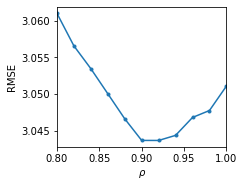

In [6]:
# Select the rho
h = [36, 32, 3, 28, 35, 4, 18, 6, 19, 14]
bs =36
rmse_list = []
for rho in np.linspace(0.8, 1, 11):
    model1 = HWDMD(h, 100, 40, rho, bs=bs)
    model1.fit(train_data, flow[:, max(h)-1:m_train-1])
    P1 = np.zeros(validate_data.shape)
    for i in range(int(validate_idx.shape[0]/bs)):
        day_idx = validate_idx[i * bs:(i * bs + bs)]
        p1 = model1.apply(data[:, day_idx], features=flow[:, day_idx-1], return_fit=True)
        P1[:, (i * bs):(i * bs + bs)] = p1
        X, Y = stagger_data(data[:, day_idx[0]-max(h): day_idx[-1]+1], h)
        X = np.concatenate([X, flow[:, day_idx-1]])
        model1.update_model(X, Y)
    rmse_list.append(RMSE(validate_data, P1))

plt.plot(np.linspace(0.8,1,11), rmse_list,'.-')

# Multi-step prediction using selected $\rho$
- The selected hyper-parameters are:
- time lag = [36, 32, 3, 28, 35, 4, 18, 6, 19, 14]
- rankx = 100, ranky=40
- $\rho$=0.92

In [8]:
h = [36, 32, 3, 28, 35, 4, 18, 6, 19, 14]
bs = 36
rho = 0.92
rx = 100
ry = 40
h.sort()
h = np.array(h)

ns = 4  # The number of steps to forecast
# To store the forecast for each step
results = {i: np.zeros((data.shape[0], validate_idx.shape[0] + test_idx.shape[0])) for i in range(1, ns + 1)}
buffer_OD = np.zeros((data.shape[0], max(2, ns - 1)))  # To store previously/current forecast OD
buffer_flow = np.zeros((num_s, 2 + ns - 1))  # To store real/forecast flow
model1 = HWDMD(h, rx, ry, rho=rho, bs=bs)
model1.fit(train_data, flow[:, max(h) - 1:m_train - 1])

# Initialize buffer OD
now = validate_idx[0] - 2
for i in range(2):
    X = data[:, now - h].reshape((-1, 1), order='F')
    X = np.concatenate([X, flow[:, [now - 1]]], axis=0)
    buffer_OD[:, [i]] = model1._forecast(X)
    now += 1

now = validate_idx[0]

# Perform the forecast over the validation and the test set
for tt in range(validate_idx.shape[0] + test_idx.shape[0]):
    buffer_flow[:, 0:2] = flow0[:, now - 2:now]
    small_data = data[:, now - max(h):now - 2]
    # The `nn`-th step forecast at `tt`
    for nn in range(ns):
        new_small_data = np.concatenate((small_data[:, nn:], buffer_OD[:, 0:nn]), axis=1)
        X = new_small_data[:, -(h - 2)].reshape((-1, 1), order='F')
        X = np.concatenate((X, buffer_flow[:, [nn + 1, nn]].reshape((-1, 1), order='F')), axis=0)
        od = model1._forecast(X)
        results[nn + 1][:, tt] = od.ravel()

        # Update buffer OD and buffer flow
        if (ns - 3) > nn:
            buffer_OD[:, nn + 2] = od.ravel()
        if (ns - 1) > nn:
            buffer_flow[:, nn + 2] = od2flow(od, num_s=num_s).ravel()

    buffer_OD[:, 0] = buffer_OD[:, 1]
    buffer_OD[:, 1] = results[1][:, tt]

    # If now is a multiple of one-day, perform online update
    if (now + 1) % 36 == 0:
        X, Y = stagger_data(data[:, now - 35 - max(h): now + 1], h)
        X = np.concatenate([X, flow[:, now - 36:now]])
        model1.update_model(X, Y)
    now += 1

test_start = len(validate_idx)
test_end = len(validate_idx) + len(test_idx)
for key, value in results.items():
    np.savez_compressed('..//data//Hangzhou_HWDMD_step{}.npz'.format(key),
                        data=value[:, test_start-(key-1) : test_end-(key-1)])

3.36195181632453
3.4133265606083047
3.4373620902890725
3.4489392808458637


In [3]:
real = data[:, test_idx]
flow0 = od2flow(data, num_s=num_s)
real_flow = flow0[:, test_idx]
predict_dmd1 = np.load('..//data//Hangzhou_HWDMD_step1.npz')['data']
predict_dmd2 = np.load('..//data//Hangzhou_HWDMD_step2.npz')['data']
predict_dmd3 = np.load('..//data//Hangzhou_HWDMD_step3.npz')['data']

print('\nResults of 1-step forecasting:')
predict_flow_dmd1 = od2flow(predict_dmd1, num_s=num_s)
get_score(real, predict_dmd1, real_flow, predict_flow_dmd1)

print('\nResults of 2-step forecasting:')
predict_flow_dmd2 = od2flow(predict_dmd2, num_s=num_s)
get_score(real, predict_dmd2, real_flow, predict_flow_dmd2)

print('\nResults of 3-step forecasting:')
predict_flow_dmd3 = od2flow(predict_dmd3, num_s=num_s)
get_score(real, predict_dmd3, real_flow, predict_flow_dmd3)


Results of 1-step forecasting:
RMSE of OD: 3.36195181632453
WMAPE of OD: 0.31762855361543507
SMAPE of OD: 0.9794777294801261
MAE of OD: 1.706554527433471
r2 of OD: 0.9339520533664918


RMSE of flow: 50.08417892456055
WMAPE of flow: 0.07381990551948547
SMAPE of flow: 0.1461678147315979
MAE of flow: 31.729564666748047
r2 of flow: 0.9894227479080007

Results of 2-step forecasting:
RMSE of OD: 3.4133265606083047
WMAPE of OD: 0.31956576335102743
SMAPE of OD: 2.7687789834193515
MAE of OD: 1.7169627668918985
r2 of OD: 0.9319180429729862


RMSE of flow: 54.13564682006836
WMAPE of flow: 0.08050967752933502
SMAPE of flow: 0.10912741720676422
MAE of flow: 34.60498809814453
r2 of flow: 0.9876422792137662

Results of 3-step forecasting:
RMSE of OD: 3.4373620902890725
WMAPE of OD: 0.31843170655001035
SMAPE of OD: 1.007607687320247
MAE of OD: 1.7108697071020484
r2 of OD: 0.9309558453531936


RMSE of flow: 56.319705963134766
WMAPE of flow: 0.08116553723812103
SMAPE of flow: -0.6482987403869629
MAE of

# Multi-step forecast when $\rho=1$

In [3]:
h = [36, 32, 3, 28, 35, 4, 18, 6, 19, 14]
bs = 36
rho = 1
rx = 100
ry = 40
h.sort()
h = np.array(h)

ns = 4  # The number of steps to forecast
# To store the forecast for each step
results = {i: np.zeros((data.shape[0], validate_idx.shape[0] + test_idx.shape[0])) for i in range(1, ns + 1)}
buffer_OD = np.zeros((data.shape[0], max(2, ns - 1)))  # To store previously/current forecast OD
buffer_flow = np.zeros((num_s, 2 + ns - 1))  # To store real/forecast flow
model1 = HWDMD(h, rx, ry, rho=rho, bs=bs)
model1.fit(train_data, flow[:, max(h) - 1:m_train - 1])

# Initialize buffer OD
now = validate_idx[0] - 2
for i in range(2):
    X = data[:, now - h].reshape((-1, 1), order='F')
    X = np.concatenate([X, flow[:, [now - 1]]], axis=0)
    buffer_OD[:, [i]] = model1._forecast(X)
    now += 1

now = validate_idx[0]

# Perform the forecast over the validation and the test set
for tt in range(validate_idx.shape[0] + test_idx.shape[0]):
    buffer_flow[:, 0:2] = flow0[:, now - 2:now]
    small_data = data[:, now - max(h):now - 2]
    # The `nn`-th step forecast at `tt`
    for nn in range(ns):
        new_small_data = np.concatenate((small_data[:, nn:], buffer_OD[:, 0:nn]), axis=1)
        X = new_small_data[:, -(h - 2)].reshape((-1, 1), order='F')
        X = np.concatenate((X, buffer_flow[:, [nn + 1, nn]].reshape((-1, 1), order='F')), axis=0)
        od = model1._forecast(X)
        results[nn + 1][:, tt] = od.ravel()

        # Update buffer OD and buffer flow
        if (ns - 3) > nn:
            buffer_OD[:, nn + 2] = od.ravel()
        if (ns - 1) > nn:
            buffer_flow[:, nn + 2] = od2flow(od, num_s=num_s).ravel()

    buffer_OD[:, 0] = buffer_OD[:, 1]
    buffer_OD[:, 1] = results[1][:, tt]

    # If now is a multiple of one-day, perform online update
    if (now + 1) % 36 == 0:
        X, Y = stagger_data(data[:, now - 35 - max(h): now + 1], h)
        X = np.concatenate([X, flow[:, now - 36:now]])
        model1.update_model(X, Y)
    now += 1

test_start = len(validate_idx)
test_end = len(validate_idx) + len(test_idx)
for key, value in results.items():
    np.savez_compressed('..//data//Hangzhou_HDMD_step{}.npz'.format(key),
                        data=value[:, test_start-(key-1) : test_end-(key-1)])

In [4]:
real = data[:, test_idx]
flow0 = od2flow(data, num_s=num_s)
real_flow = flow0[:, test_idx]
predict_dmd1 = np.load('..//data//Hangzhou_HDMD_step1.npz')['data']
predict_dmd2 = np.load('..//data//Hangzhou_HDMD_step2.npz')['data']
predict_dmd3 = np.load('..//data//Hangzhou_HDMD_step3.npz')['data']

print('\nResults of 1-step forecasting:')
predict_flow_dmd1 = od2flow(predict_dmd1, num_s=num_s)
get_score(real, predict_dmd1, real_flow, predict_flow_dmd1)

print('\nResults of 2-step forecasting:')
predict_flow_dmd2 = od2flow(predict_dmd2, num_s=num_s)
get_score(real, predict_dmd2, real_flow, predict_flow_dmd2)

print('\nResults of 3-step forecasting:')
predict_flow_dmd3 = od2flow(predict_dmd3, num_s=num_s)
get_score(real, predict_dmd3, real_flow, predict_flow_dmd3)


Results of 1-step forecasting:
RMSE of OD: 3.397137382039478
WMAPE of OD: 0.31938323448580724
SMAPE of OD: 0.9605407849544783
MAE of OD: 1.7159820758999105
r2 of OD: 0.9325623277381635


RMSE of flow: 51.28380584716797
WMAPE of flow: 0.0754397064447403
SMAPE of flow: 0.11305169016122818
MAE of flow: 32.4257926940918
r2 of flow: 0.9889099816679708

Results of 2-step forecasting:
RMSE of OD: 3.453673292253543
WMAPE of OD: 0.32217582533329336
SMAPE of OD: 0.9768320021277477
MAE of OD: 1.7309861065508096
r2 of OD: 0.9302990247069941


RMSE of flow: 55.6634635925293
WMAPE of flow: 0.08285234123468399
SMAPE of flow: 0.1629759967327118
MAE of flow: 35.61192321777344
r2 of flow: 0.9869349178419045

Results of 3-step forecasting:
RMSE of OD: 3.4822717048800613
WMAPE of OD: 0.3213102167241722
SMAPE of OD: 0.9791671071296187
MAE of OD: 1.7263353650665614
r2 of OD: 0.9291399166644746


RMSE of flow: 58.45131301879883
WMAPE of flow: 0.08433608710765839
SMAPE of flow: 0.12279949337244034
MAE of flo